In [30]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

class InsufficientData(Exception):
    def __str__(self):
        string_exp = 'Данных недостаточно. Их должно быть не менее 2^k строк, \
где k – количество признаков. Если признак 1, то хотя бы 10 строк.'
        return string_exp


class LinearlyDependent(Exception):
    def __str__(self):
        return 'Присутствуют линейно зависимые признаки. Мы не можем применить МНК.'


class DegreeError(Exception):
    def __str__(self):
        return 'Степень полинома должна быть целым неотрицательным числом.'


class NegativeValue(Exception):
    def __str__(self):
        return 'Значения y должны быть положительными'


class VeryBig(Exception):
    def __str__(self):
        return 'Свободный член получился слишком большим, чтобы произвести вычисления'
    
class RegularizationError(Exception):
    def __str__(self):
        return 'К сожалению, мы не можем построить полиномиальную регрессию с регулязацией'

    
def student_del(X, y):
    X_new = X.copy()
    y_new = y.copy()
    for line in range(len(X)):
        if len(X.shape) == 2:
            if X_new.drop(index=line).var().sum() < X_new.var().sum():
                X_new = X_new.drop(index=line)
                y_new = y_new.drop(index=line)
        else:
            if X_new.drop(index=line).var() < X_new.var():
                X_new = X_new.drop(index=line)
                y_new = y_new.drop(index=line)
    return X_new, y_new


def check_data(X):
    if len(X.shape) == 2 and X.shape[1] > 1:
        if X.shape[0] < 2**X.shape[1] or len(X) < 10:
            raise InsufficientData
    else:
        if len(X) < 10:
            raise InsufficientData


def plot_3d_regression(X, y, coef, a0, n_point=7000):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], y, marker='.', color='red')
    ax.set_xlabel("X0")
    ax.set_ylabel("X1")
    ax.set_zlabel("y")

    xs = np.tile(np.arange(n_point), (n_point,1))
    ys = np.tile(np.arange(n_point), (n_point,1)).T
    zs = a0 * np.exp(coef[0]*xs) * np.exp(ys * coef[1])
    ax.plot_surface(xs, ys, zs, alpha=0.5)
    plt.show()


def plot_2d_regression(X, y, coef, a0, reg_type):
    xs = np.linspace(X.min()-1, X.max()+1)
    if reg_type == 'lin':
        zs = a0 + xs*coef
    else:
        zs = a0 * np.exp(coef*xs)
    plt.plot(xs, zs, color="blue", linewidth=3, label='Прогноз')
    plt.scatter(X, y, marker='.', color='red', label='Исходные') 
    plt.legend()
    plt.show()



def exp_regression(X, y, tol=5, regularization=None, alpha=1.0, draw=False):
    if not (y > 0).all():
        raise NegativeValue
    y_new = np.log(y)
    check_data(X)
    if len(X.shape) < 2:
        X = X.to_numpy().reshape(-1, 1)
            
    if regularization is None:
        if X.shape[1] >= 2 and np.linalg.det(X.T@X) == 0:
            raise LinearlyDependent
        reg = LinearRegression().fit(X, y_new)
    elif regularization == 'L1':
        reg = Lasso(alpha=alpha).fit(X, y_new)
    elif regularization == 'L2':
        reg = Ridge(alpha=alpha).fit(X, y_new)
    elif regularization == 'Student':
        X_new, y_log_new = student_del(pd.DataFrame(X), 
                                       pd.DataFrame(y_new))
        check_data(X_new)
        if len(X_new.shape) < 2:
            X_new = X_new.to_numpy().reshape(-1, 1)
        reg = LinearRegression().fit(X_new, y_log_new)
    X = pd.DataFrame(X)
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            if regularization == 'Student':
                weights, bias = reg.coef_[0], np.exp(reg.intercept_)[0]
            else:
                weights, bias = reg.coef_, np.exp(reg.intercept_)
    except RuntimeWarning:
        raise VeryBig
    if X.shape[1] >= 2:
        func = f'{round(bias, tol)}'
        k = len(weights)
        for i in range(k):
            coef = weights[i]
            func = func + f' * exp({round(coef, tol)}*x{k-i})'
    else:
        weights = weights[0]
        bias = bias
        func = f'{round(bias, tol)}' + f' * exp({round(weights, tol)}*x0)'
    if draw == True and X.shape[1] > 2:
        print('К сожалению, мы не можем построить график, так как размерность пространства признаков велика.')
    elif draw == True and X.shape[1] == 2:
        plot_3d_regression(X, y, weights, bias)
    elif draw == True and X.shape[1] == 1:
        plot_2d_regression(X, y, weights, bias, reg_type='exp')
    return {'func': func, 
            'weights': weights, 
            'bias': bias}


def poly_regression(X, y, degree, tol=5, regularization=None, alpha=1.0, draw=False):
    
    if degree <= 0 or type(degree)!=int: 
        raise DegreeError
        
    check_data(X)
    if len(X.shape) < 2:
        X = X.to_numpy().reshape(-1, 1)
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    if regularization is not None and degree>1:
        raise RegularizationError
    
    if X.shape[1] >= 2 and np.linalg.det(X.T@X) == 0:
        raise LinearlyDependent
    reg = LinearRegression().fit(X_poly, y)

    
    if regularization == 'Student':
        weights, bias = reg.coef_[0], reg.intercept_[0]
    else:
        weights, bias = reg.coef_, reg.intercept_    

    X_poly = pd.DataFrame(X_poly)


    if X.shape[1] == 1 and degree == 1 : # 1 признак 
        weights = weights[1] # weights[0] относится к вспомогательному x
        func = f'{round(bias, tol)} + {round(weights, tol)}*x1'
    elif X.shape[1]==1 and degree>1: # 1 признак
        func = f'{round(bias, tol)}' # a0
        for i in range(1, degree+1):
            func = func + f' + {round(weights[i], tol)}*x1^{i}'
    elif X.shape[1]>=2 and degree==1:
        func = f'{round(bias, tol)}' # a0
        for i in range(len(weights)-1):
            func = func + f' + {round(weights[i+1], tol)}*x{i+1}'
    else: 
        func = 'К сожалению, мы не можем вывести функцию для множественной полиномиальной регрессии'
    
    if draw == True and X.shape[1] == 1 and degree==1: # a0+a1*x1
        plot_2d_regression(X, y, weights, bias, reg_type='lin')
    elif draw==True and (X.shape[1]==2 and degree==1): # or  (X.shape[1]==1 degree==2)   
        # a0 + a1*x1 + a2*x2
        plot_3d_regression(X, y, weights, bias)
    else:
        print('К сожалению, мы не можем построить график, так как размерность пространства признаков велика.')
        
    return {'func': func, 
            'weights': weights, 
            'bias': bias}


def lin_regression(X, y, tol = 5, regularization = None, alpha=1.0, draw = False):
    y_new = y.to_numpy()
    check_data(X)

    if len(X.shape) < 2:
        X = X.to_numpy().reshape(-1, 1)

    if regularization is None:
        reg = LinearRegression().fit(X, y_new)
    elif regularization == 'L1':
        reg = Lasso(alpha=alpha).fit(X, y_new)
    elif regularization == 'L2':
        reg = Ridge(alpha=alpha).fit(X, y_new)

    elif regularization == 'Student':
        X_new, y_new = student_del(pd.DataFrame(X), 
                                       pd.DataFrame(y_new))
        check_data(X_new)
        if len(X_new.shape) < 2:
            X_new = X_new.to_numpy().reshape(-1, 1)
        reg = LinearRegression().fit(X_new, y_new)

    if regularization == 'Student':
        weights, bias = reg.coef_[0], reg.intercept_[0]
    else:
        weights, bias = reg.coef_, reg.intercept_
    func = str(round(bias, tol)) + ' '
    for i in range(len(weights)):
        if str(weights[i])[0] == '-':
            func += str(round(weights[i], tol)) + 'x' + str(i + 1) + ' '
        else:
            func += '+ ' + str(round(weights[i], tol)) + 'x' + str(i + 1) + ' '
    if draw == True and X.shape[1] > 2:
        print('К сожалению, мы не можем построить график, так как размерность пространства признаков велика.')
    elif draw == True and X.shape[1] == 2:
        plot_3d_regression(X, y, weights, bias, n_point = 7000)
    elif draw == True and X.shape[1] == 1:
        plot_2d_regression(X, y, weights, bias, reg_type='lin')
    return {'func': func[:-1], 
            'weights': weights, 
            'bias': bias}


In [2]:
  pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
from decimal import Decimal

In [4]:
aapl = yf.download('AAPL', '2021-01-01', '2022-01-01')

[*********************100%***********************]  1 of 1 completed


In [5]:
aapl = aapl.reset_index(level=0)

In [6]:
aapl

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-31,134.080002,134.740005,131.720001,132.690002,131.709213,99116600
1,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.453445,143301900
2,2021-01-05,128.889999,131.740005,128.429993,131.009995,130.041626,97664900
3,2021-01-06,127.720001,131.050003,126.379997,126.599998,125.664215,155088000
4,2021-01-07,128.360001,131.630005,127.860001,130.919998,129.952286,109578200
...,...,...,...,...,...,...,...
248,2021-12-27,177.089996,180.419998,177.070007,180.330002,180.100540,74919600
249,2021-12-28,180.160004,181.330002,178.529999,179.289993,179.061859,79144300
250,2021-12-29,179.330002,180.630005,178.139999,179.380005,179.151749,62348900
251,2021-12-30,179.470001,180.570007,178.089996,178.199997,177.973251,59773000


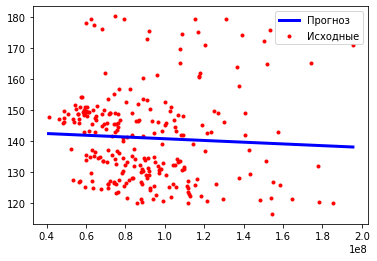

{'func': '143.4969 -0.0x1',
 'weights': array([-2.80518306e-08]),
 'bias': 143.49689552425573}

In [7]:
lin_regression(aapl['Volume'], aapl['Close'], draw=True)

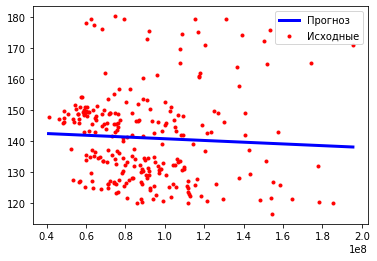

{'func': '143.4969 -0.0x1',
 'weights': array([-2.80518294e-08]),
 'bias': 143.4968954172224}

In [8]:
lin_regression(aapl['Volume'], aapl['Close'], regularization='L1', draw=True)

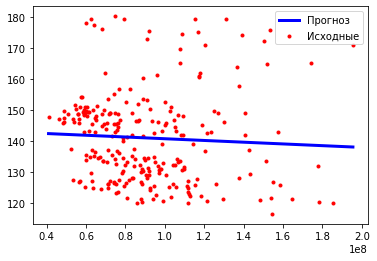

{'func': '143.4969 -0.0x1',
 'weights': array([-2.80518306e-08]),
 'bias': 143.49689552425573}

In [9]:
lin_regression(aapl['Volume'], aapl['Close'], regularization='L2', draw=True)

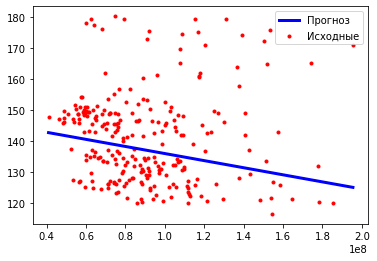

{'func': '147.36768 -0.0x1',
 'weights': array([-1.1470896e-07]),
 'bias': 147.36768234788852}

In [10]:
lin_regression(aapl['Volume'], aapl['Close'], regularization='Student', draw=True)

/var/folders/kl/3j2f8l694z5gbwslbf7_lcl00000gq/T/ipykernel_51749/1791197904.py:73: RuntimeWarning: overflow encountered in exp
  zs = a0 * np.exp(coef[0]*xs) * np.exp(ys * coef[1])
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1814: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1813: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2559: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


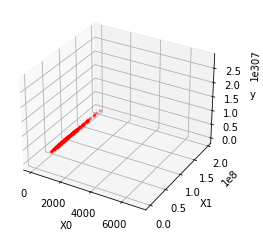

{'func': '0.33484 + 1.00285x1 -0.0x2',
 'weights': array([ 1.00285297e+00, -6.79275179e-09]),
 'bias': 0.33484499207307294}

In [11]:
lin_regression(aapl[['Open', 'Volume']], aapl['Close'], draw=True)

/var/folders/kl/3j2f8l694z5gbwslbf7_lcl00000gq/T/ipykernel_51749/1791197904.py:73: RuntimeWarning: overflow encountered in exp
  zs = a0 * np.exp(coef[0]*xs) * np.exp(ys * coef[1])
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1814: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1813: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2559: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site

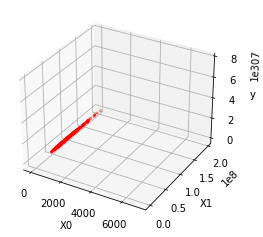

{'func': '0.67768 + 1.00045x1 -0.0x2',
 'weights': array([ 1.0004514e+00, -6.8436611e-09]),
 'bias': 0.6776803551717308}

In [12]:
lin_regression(aapl[['Open', 'Volume']], aapl['Close'], regularization='L1', alpha=0.5, draw=True)

/var/folders/kl/3j2f8l694z5gbwslbf7_lcl00000gq/T/ipykernel_51749/1791197904.py:73: RuntimeWarning: overflow encountered in exp
  zs = a0 * np.exp(coef[0]*xs) * np.exp(ys * coef[1])
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1814: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1813: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2559: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


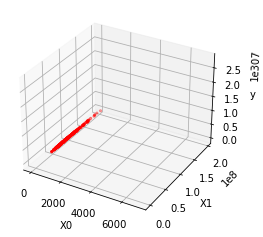

{'func': '0.33756 + 1.00283x1 -0.0x2',
 'weights': array([ 1.00283393e+00, -6.79315538e-09]),
 'bias': 0.33756283615903726}

In [13]:
lin_regression(aapl[['Open', 'Volume']], aapl['Close'], regularization='L2', draw=True)

/var/folders/kl/3j2f8l694z5gbwslbf7_lcl00000gq/T/ipykernel_51749/1791197904.py:73: RuntimeWarning: overflow encountered in exp
  zs = a0 * np.exp(coef[0]*xs) * np.exp(ys * coef[1])
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1814: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1813: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/numpy/core/numeric.py:1660: RuntimeWarning: overflow encountered in multiply
  multiply(a1, b2, out=cp0)
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/numpy/core/numeric.py:1661: RuntimeWarning: overflow encountered in multiply
  tmp = array(a2 * b1)
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/numpy/core/numeric.py:1663: Runt

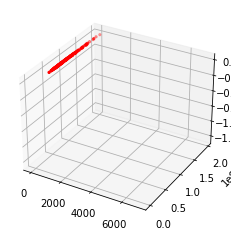

{'func': '-1.62848 + 1.0128x1 + 0.0x2',
 'weights': array([1.01279994e+00, 1.22567881e-09]),
 'bias': -1.628483010520057}

In [14]:
lin_regression(aapl[['Open', 'Volume']], aapl['Close'], regularization='Student', draw=True)

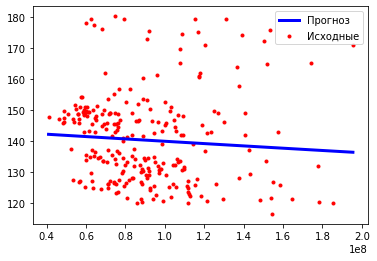

{'func': '143.6968 * exp(-0.0*x0)',
 'weights': -2.697485449323164e-10,
 'bias': 143.6967960345703}

In [15]:
exp_regression(aapl['Volume'], aapl['Close'], draw=True)

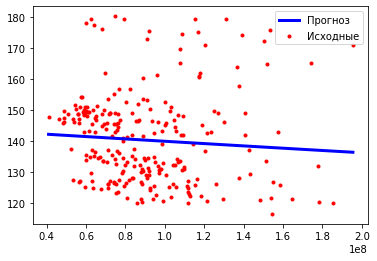

{'func': '143.69678 * exp(-0.0*x0)',
 'weights': -2.697473630083398e-10,
 'bias': 143.69678065421934}

In [16]:
exp_regression(aapl['Volume'], aapl['Close'], regularization='L1', draw=True)

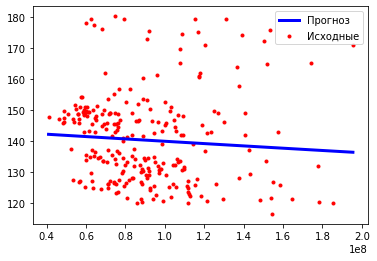

{'func': '143.6968 * exp(-0.0*x0)',
 'weights': -2.6974854493231626e-10,
 'bias': 143.6967960345703}

In [17]:
exp_regression(aapl['Volume'], aapl['Close'], regularization='L2', draw=True)

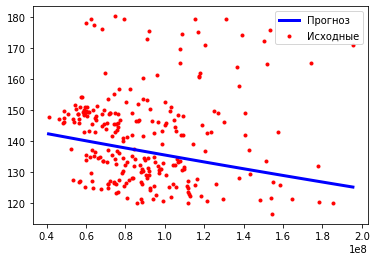

{'func': '147.21398 * exp(-0.0*x0)',
 'weights': -8.349581136381824e-10,
 'bias': 147.21397731807374}

In [18]:
exp_regression(aapl['Volume'], aapl['Close'], regularization='Student', draw=True)

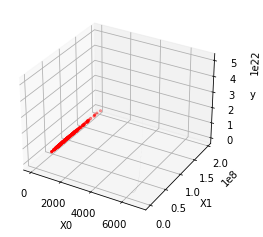

{'func': '53.65871 * exp(0.0069*x2) * exp(-0.0*x1)',
 'weights': array([ 6.90037621e-03, -1.23470232e-10]),
 'bias': 53.65871210516068}

In [19]:
exp_regression(aapl[['Open', 'Volume']], aapl['Close'], regularization=None, draw=True)

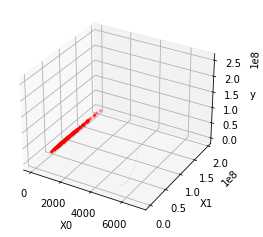

{'func': '106.51812 * exp(0.0021*x2) * exp(-0.0*x1)',
 'weights': array([ 2.09723472e-03, -2.25288924e-10]),
 'bias': 106.51812079707067}

In [20]:
exp_regression(aapl[['Open', 'Volume']], aapl['Close'], regularization='L1', draw=True)

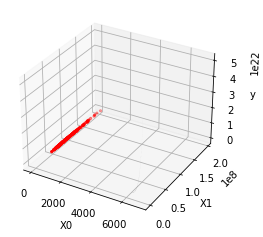

{'func': '53.65972 * exp(0.0069*x2) * exp(-0.0*x1)',
 'weights': array([ 6.90024521e-03, -1.23473009e-10]),
 'bias': 53.65971557505444}

In [21]:
exp_regression(aapl[['Open', 'Volume']], aapl['Close'], regularization='L2', draw=True)

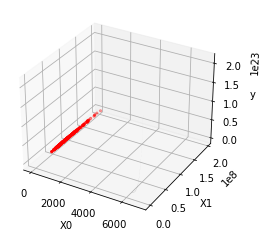

{'func': '51.73308 * exp(0.00711*x2) * exp(-0.0*x1)',
 'weights': array([ 7.10874460e-03, -2.12241214e-11]),
 'bias': 51.73308489422613}

In [22]:
exp_regression(aapl[['Open', 'Volume']], aapl['Close'], regularization='Student', draw=True)

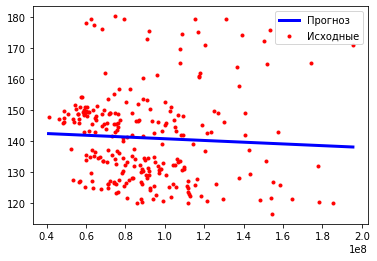

{'func': '143.4969 + -0.0*x1',
 'weights': -2.805183057424643e-08,
 'bias': 143.49689552425573}

In [28]:
poly_regression(aapl['Volume'], aapl['Close'], degree=1, draw=True)

/var/folders/kl/3j2f8l694z5gbwslbf7_lcl00000gq/T/ipykernel_51749/1478365566.py:73: RuntimeWarning: overflow encountered in exp
  zs = a0 * np.exp(coef[0]*xs) * np.exp(ys * coef[1])
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1814: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:1813: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2559: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/Users/kikonstantinov/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


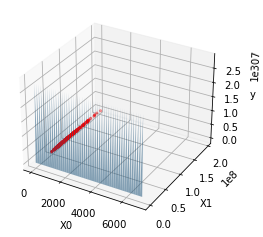

{'func': '0.33485 + 1.00285*x1 + -0.0*x2',
 'weights': array([ 0.00000000e+00,  1.00285297e+00, -6.79275192e-09]),
 'bias': 0.334845004111088}

In [31]:
poly_regression(aapl[['Open', 'Volume']], aapl['Close'], degree=1, draw=True)